# Upotreba nekoliko algoritama mašinskog učenja na primeru odnosa visine i težine učesnika 3 timska sporta na letnjoj olimpijadi 2016

#### Na sajtu www.kaggle.com nalazi se i dataset "2016 Olympics in Rio de Janeiro" koji ima csv fajl "Athletes.csv" na kom se nalaze podaci o svim sportistima koji su učestvovali na poslednjoj letnjoj olimpijadi. Za svakog sportistu postoji ID kolona, njegovo ime i prezime, datum rođenja, pol, sport kojim se bavi, visina, težina, država, i broj medalja. Kao što je poznato, na poslednjoj letnjoj olimpijadi (Rio 2016) Srbija je u timskim sportovima imala čak 3 finalista. Košarkaši, vaterpolisti i odbojkašice su stizali do finala, i ovo je projekat iz mašinskog učenja koji prvo izdvaja učesnike iz te tri konkurencije (muška-košarka, muški-vaterpolo, ženska-odbojka), grafički prikazuje i analizira te podatke, a onda se i osposobljava da prepoznaje sportiste u ove tri konkurencije na osnovu njihove kombinacije visine i težine.


### Najava korišćenih biblioteka i paketa

In [1]:
import pandas as pd
import numpy as np
import os
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
%matplotlib inline
# prvo su najavljeni softverske biblioteke i paketi koji će biti korišćeni

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# zatim i programski paketi koji će se koristiti za potrebe klasifikacije

### Učitavanje fajlova

In [3]:
data3 = pd.read_csv(r'C:\Users\Drax\Desktop\Rio2016_basket_polo_volley.csv')
data = pd.read_csv(r'C:\Users\Drax\Desktop\athletes.csv')


#### Na desktopu je učitan fajl "athletes.csv", ali se ispostavilo da postoji problem sa učesnicima olimpijskog vaterpolo turnira, jer vaterpolo nije dat posebno, nego samo u okviru tzv vodenih sportova. Zato je napravljen poseban pomoćni fajl "Rio2016_basket_polo_volley.csv" gde su izdvojeni isključivo sportisti iz ove tri konkurencije. Ali u ovom projektu paralelno će se analizirati i podaci sa orginalnog dataseta gde su vaterpolisti izmešani sa ostalim učesnicima iz vodenih sportova u muškoj konkurenciji (dataframe data), kao i potpuno pročišćeni podaci za ova tri sporta (dataframe data3) 

#### Zatim ćemo preko .head() opcije da pogledamo prvih 5 redova obe tabele.

In [4]:
print(data.head(5))
print(data.shape)
print()
data.info()
print()
print(data3.head(5))
print(data3.shape)
# kratak uvid u 11 kolona koje sadrže ove dve tabele, i u njene dimenzije

          id            name nationality     sex       dob  height  weight  \
0  736041664  A Jesus Garcia         ESP    male  10/17/69    1.72    64.0   
1  532037425      A Lam Shin         KOR  female   9/23/86    1.68    56.0   
2  435962603     Aaron Brown         CAN    male   5/27/92    1.98    79.0   
3  521041435      Aaron Cook         MDA    male    1/2/91    1.83    80.0   
4   33922579      Aaron Gate         NZL    male  11/26/90    1.81    71.0   

       sport  gold  silver  bronze  
0  athletics     0       0       0  
1    fencing     0       0       0  
2  athletics     0       0       1  
3  taekwondo     0       0       0  
4    cycling     0       0       0  
(11538, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
id             11538 non-null int64
name           11538 non-null object
nationality    11538 non-null object
sex            11538 non-null object
dob            11537 non-null object
hei

### Izdvajanje podataka za samo tri sporta koji nas zanimaju, brisanje nepotrebnih kolona i izbacivanje sportista sa nepotpunim podacima o visini i težini

In [5]:
data = data[((data.sport == 'volleyball') & (data.sex == 'female')) | 
            ((data.sport == 'basketball') & (data.sex == 'male')) | 
            ((data.sport == 'aquatics') & (data.sex == 'male') & (data.nationality.isin(['SRB','MNE','CRO','HUN','GRE','ITA','ESP','FRA','USA','JPN','AUS','BRA'])))]
print(data.shape, data3.shape)

(682, 11) (492, 11)


#### Kao što je rečeno, u datafrejmu 'data3' su već izdvojene samo tri konkurencije koje nas zanimaju (a u okviru vodenih sportova samo vaterpolisti), pa smo ovde i u datafrejmu 'data' sačuvali samo mušku-košarku, žensku odbojku i muške vodene sportove iz kojih smo odstranili sve učesnike iz zemalja koje nisu učestvovale na 2016 vaterpolo turniru, tako da nam je od orginalnih preko 11 hiljada sportista ostalo manje od 700.

#### Zatim ćemo izbaciti iz obe tabele sve nepotrebne kolone koja nam nisu potrebne za ovaj rad (id, datum rodjenja i kolone o medaljama).

In [6]:
data.drop('id',axis=1,inplace=True) 
data.drop('dob',axis=1,inplace=True)
data.drop('gold',axis=1,inplace=True)
data.drop('silver',axis=1,inplace=True)
data.drop('bronze',axis=1,inplace=True)
print(data.head(5))
print()

data3.drop('id',axis=1,inplace=True)
data3.drop('dob',axis=1,inplace=True)
data3.drop('gold',axis=1,inplace=True)
data3.drop('silver',axis=1,inplace=True)
data3.drop('bronze',axis=1,inplace=True)
print(data3.head(5))

                   name nationality     sex  height  weight       sport
7         Aaron Younger         AUS    male    1.93   100.0    aquatics
46  Abdoulkarim Fawziya         CMR  female    1.80    67.0  volleyball
75          Adam Decker         HUN    male    2.03   115.0    aquatics
87         Adam Telegdy         HUN    male    1.94    77.0    aquatics
95     Adas Juskevicius         LTU    male    1.94    90.0  basketball

                  name nationality     sex  height  weight       sport
0        Aaron Younger         AUS    male    1.93   100.0    aquatics
1  Abdoulkarim Fawziya         CMR  female    1.80    67.0  volleyball
2          Adam Decker         HUN    male    2.03   115.0    aquatics
3     Adas Juskevicius         LTU    male    1.94    90.0  basketball
4    Adenizia da Silva         BRA  female    1.87    65.0  volleyball


#### I na kraju, izbacivanje sportista sa nepotpunim podacima.

In [7]:
print(data.shape, data3.shape)
data = data[np.isfinite(data['height'])]
data = data[np.isfinite(data['weight'])]
data3 = data3[np.isfinite(data3['height'])]
data3 = data3[np.isfinite(data3['weight'])]
print(data.shape, data3.shape)
# Izbačeni su sada i oni sportisti kojima nije navedena visina ili težina, pošto će se sve dalje u ovom projektu
# oslanjati baš na ta dva podatka

(682, 6) (492, 6)
(675, 6) (487, 6)


### Vizuelna prezentacija podataka 

#### Prikazaćemo grafički sve sportiste u ove tri konkurencije preko njihove težine i visine. Tačke koje predstavljaju košarkaše su obojene u narandžasto, vodene sportove u plavo, a odbojkašice u crveno.

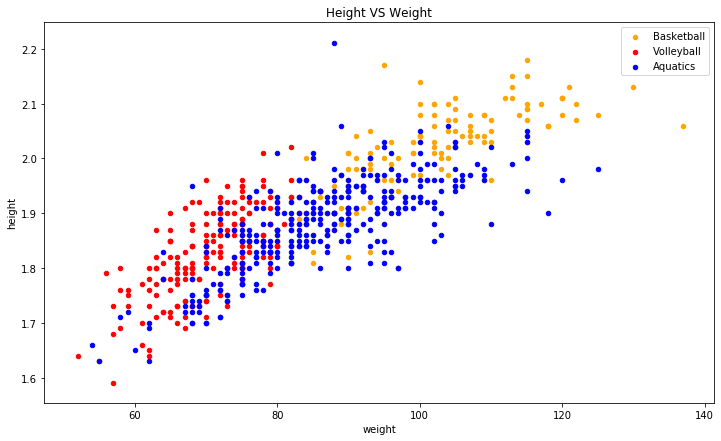

In [8]:
fig = data[data.sport=='basketball'].plot(kind='scatter',x='weight',y='height',color='orange', label='Basketball')
data[data.sport=='volleyball'].plot(kind='scatter',x='weight',y='height',color='red', label='Volleyball',ax=fig)
data[data.sport=='aquatics'].plot(kind='scatter',x='weight',y='height',color='blue', label='Aquatics', ax=fig)
fig.set_xlabel("weight")
fig.set_ylabel("height")
fig.set_title("Height VS Weight")
fig=plt.gcf()
fig.set_size_inches(12,7)
plt.show()

#### A sada ćemo to isto da uradimo sa tabelom 'data3' u kojoj su izdvojeni samo vaterpolisti od predstavnika vodenih sportova. 

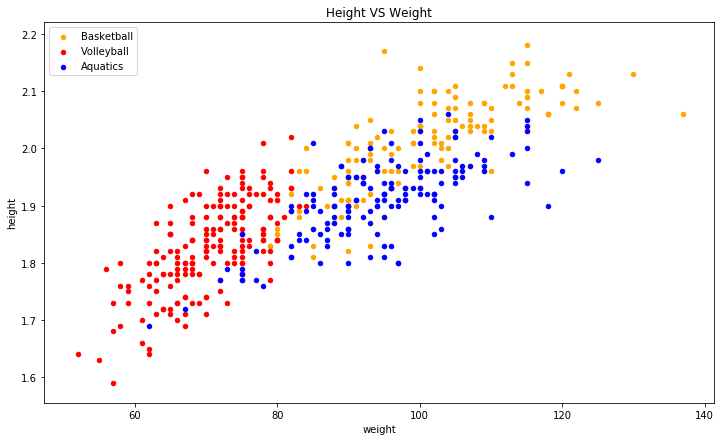

In [9]:
fig = data3[data3.sport=='basketball'].plot(kind='scatter',x='weight',y='height',color='orange', label='Basketball')
data3[data3.sport=='volleyball'].plot(kind='scatter',x='weight',y='height',color='red', label='Volleyball',ax=fig)
data3[data3.sport=='aquatics'].plot(kind='scatter',x='weight',y='height',color='blue', label='Aquatics', ax=fig)
fig.set_xlabel("weight")
fig.set_ylabel("height")
fig.set_title("Height VS Weight")
fig=plt.gcf()
fig.set_size_inches(12,7)
plt.show()
# Isto to je urađeno i sa datafrejmom data3 gde se od "vodenih sportova" nalaze samo vaterpolisti iz muške konkurencije

#### Preko odgovarajućih histagrama vidimo kako su preraspodeljeni visina i težina u ova tri sporta.

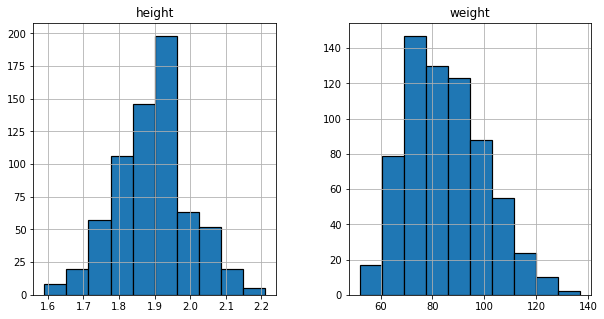

In [10]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

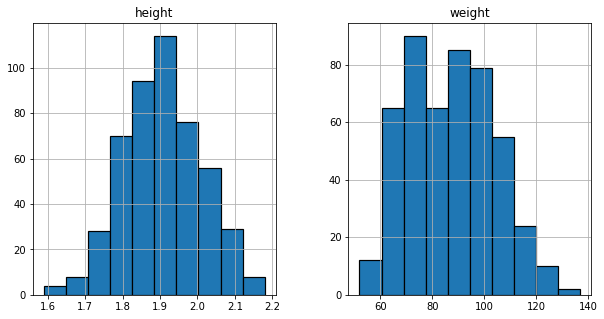

In [11]:
data3.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

## Primena mašinskog učenja

### Podela datafrejmova na trening i test deo

In [12]:
train, test = train_test_split(data, test_size = 0.25)
print(train.shape, test.shape)

train3, test3 = train_test_split(data3, test_size = 0.25)
print(train3.shape, test3.shape)

trainSRB = data3[(data3.nationality != 'SRB')]
testSRB = data3[(data3.nationality == 'SRB')]
print(trainSRB.shape, testSRB.shape)

(506, 6) (169, 6)
(365, 6) (122, 6)
(450, 6) (37, 6)


#### Iz oba datafrejma (i onog gde su samo vaterpolisti iz vodenih sportova, i onog gde nisu), uzet je slučajan uzorak za trening i za testiranje u odnosu 75% / 25%, a za potrebe eksperimentisanja napravili smo i treći par gde će nam, za potrebe testiranja služiti samo izdvojeni sportisti iz Srbije, a za trening iz ostatka sveta.

In [13]:
train_X = train[['height','weight']]
train_y = train.sport
test_X = test[['height','weight']]
test_y = test.sport 

train3_X = train3[['height','weight']]
train3_y = train3.sport
test3_X = test3[['height','weight']]
test3_y = test3.sport

trainSRB_X = trainSRB[['height','weight']]
trainSRB_y = trainSRB.sport
testSRB_X = testSRB[['height','weight']]
testSRB_y = testSRB.sport

#### Kao što je već najavljeno u uvodu, u fokusu su nam visina i težina nekog sportiste u odnosu na sport kojim se bavi i paralelno ćemo posmatrati za sve ove tri izdvojene grupe koje smo odredili za treninge (odnosno testiranje).

In [14]:
print(train_X.head(5))
print()
print(train3_X.head(5))
print()
print(trainSRB_X.head(5))

       height  weight
11113    1.84    75.0
2175     1.86    77.0
10590    1.77    75.0
3206     1.89    90.0
5567     1.84    84.0

     height  weight
127    1.78    69.0
183    1.86    90.0
192    1.72    64.0
318    1.78    75.0
9      1.91    95.0

   height  weight
0    1.93   100.0
1    1.80    67.0
2    2.03   115.0
3    1.94    90.0
4    1.87    65.0


#### Da primetimo razlike između sva tri uzorka već na osnovu prvih pet sportista koji im pripadaju

In [15]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# Blokirali smo za svaki slučaj opciju upozoravanja da se ne bi stvarala konfuzija pri prezentaciji rezultata
# različitih algoritama klasifikacije i mašinskog učenja

### SVM algoritam (support vector machines)

#### Prvo ćemo isprobati SVM algoritam (Support Vector Machines) i utvrditi sa kojom preciznošću će pravilno klasifikovati sport samo na osnovu visine i težine sportiste, i uočiti sa kojom preciznošću su izvršena predvidjanja kojim sportom se bave sportisti iz test grupe. 

In [18]:
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('Preciznost SVM algoritma je (data):',round(metrics.accuracy_score(prediction,test_y), 2))

model = svm.SVC()
model.fit(train3_X,train3_y)
prediction=model.predict(test3_X)
print('Preciznost SVM algoritma je (data3):',round(metrics.accuracy_score(prediction,test3_y), 2))

model = svm.SVC()
model.fit(trainSRB_X,trainSRB_y)
prediction=model.predict(testSRB_X)
print('Preciznost SVM algoritma je (dataSRB):',round(metrics.accuracy_score(prediction,testSRB_y), 2))



Preciznost SVM algoritma je (data): 0.65
Preciznost SVM algoritma je (data3): 0.66
Preciznost SVM algoritma je (dataSRB): 0.73


### Logistic Regression 

In [19]:
model = LogisticRegression()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('Preciznost Logistic Regression algoritma (data):',round(metrics.accuracy_score(prediction,test_y),2 ))

model = LogisticRegression()
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Preciznost Logistic Regression algoritma (data3):',round(metrics.accuracy_score(prediction,test3_y), 2))

model = LogisticRegression()
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Preciznost Logistic Regression algoritma (dataSRB):',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# Zatim smo na sva tri uzorka isprobali logičku regresiju (Logistic Regression)

Preciznost Logistic Regression algoritma (data): 0.67
Preciznost Logistic Regression algoritma (data3): 0.76
Preciznost Logistic Regression algoritma (dataSRB): 0.84


### Decision Tree Classifier 

In [20]:
model = DecisionTreeClassifier()
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('Preciznost Decision Tree algoritma (data)',round(metrics.accuracy_score(prediction,test_y),2 ))

model = DecisionTreeClassifier()
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Preciznost Decision Tree algoritma (data3)',round(metrics.accuracy_score(prediction,test3_y), 2))

model = DecisionTreeClassifier()
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Preciznost Decision Tree algoritma (dataSRB)',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# Sledeći je ispitan algoritam Decision Tree Classifier i njegova preciznost predviđanja na ova 3 uzorka

Preciznost Decision Tree algoritma (data) 0.69
Preciznost Decision Tree algoritma (data3) 0.72
Preciznost Decision Tree algoritma (dataSRB) 0.73


### KNN algoritam (k-Nearest Neighbor)

In [21]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('Preciznost KNN algoritma (data)',round(metrics.accuracy_score(prediction,test_y), 2))

model = KNeighborsClassifier(n_neighbors=3)
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Preciznost KNN algoritma (data)',round(metrics.accuracy_score(prediction,test3_y), 2))

model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Preciznost KNN algoritma (data)',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# I na kraju je ispitan KNN algoritam (k-Nearest Neighbor) i njegova preciznost predviđanja na ova 3 uzorka

Preciznost KNN algoritma (data) 0.66
Preciznost KNN algoritma (data) 0.74
Preciznost KNN algoritma (data) 0.7


## Zaključci na osnovu rezultata 

#### Samo na osnovu visine i težine sportiste u grupi gde su izmešani košarkaši, vaterpolisti i odbojkašice, može se sa relativno dosta uspešno pogoditi o predstavniku kog sporta je reč. Procenat uspešnosti je bio najniži tamo gde su vaterpolisti izmešani sa predstavnicima ostalih vodenih sportova, jer je preklapanje sa odbojkašicama onda tu veće.

#### Vidno veću preciznost smo dobili tamo gde su vaterpolisti bili izdvojeni od ostalih vodenih sportova, jer je zakonomernost u odnosu visine i težine kod vaterpolista jasnija nego kod predstavnika vodenih sportova u celini. 

#### Najveću preciznost smo postigli tamo gde smo izdvojili samo srpske sportiste, a trenirali na svima ostalima. To se  dogodilo uprkos činjenici da su srpske odbojkašice u proseku po visini i težini bile iznad proseka za svoj sport, pa samim tim sličnije vaterpolistima i košarkaškim bekovima, a i da su srpski vaterpolisti u proseku takodje bili iznad proseka za svoj sport, pa samim tim bliži košarkašima. Ali pošto su svi došli do finala, onda je i za očekivati da se više od proseka njihov odnos visine i težine uklapa u nekakve idealne standarde koji važe za njihov sport u sva tri slučaja (i naši košarkaši, i vaterpolisti, i odbojkašice).
